<div style="text-align: center;">
  <span style="font-size: 24px; font-weight: bold;">Data Mining Project Technical Report</span>
</div>

<span style="font-size:22px;font-weight:bold"> 1.Introduction </span>

<span style="font-size:18px;font-weight:bold"> 1.1 Project Overview </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This project aims to perform anomaly detection on
</span>


<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This project aims to perform anomaly detection on a multivariate time series Server Machine Dataset using a ConvBiGRU Autoencoder model. Anomaly detection is crucial for ensuring stable server operation, helping us identify potential issues in a timely manner and take appropriate measures. This is particularly important in complex systems with multiple interacting metrics, where anomalies can be subtle and difficult to detect manually.
</span>

<span style="font-size:18px;font-weight:bold"> 1.2 Problem Definition </span>


<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The anomaly detection problem in the multivariate time series Server Machine Dataset focuses on identifying abnormal behaviors that diverge from typical operating conditions. This requires detecting deviations across the dataset's numerous metrics simultaneously. The sheer dimensionality of the data necessitates a model capable of learning complex relationships between these features, regardless of their individual identities.
</span>

<span style="font-size:18px;font-weight:bold"> 1.3 Methodology Overview </span>


<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; I adopted an unsupervised learning approach based on a ConvBiGRU Autoencoder to address the challenges of multivariate time series anomaly detection. First, I preprocessed the data, then used convolutional layers to extract features that capture inter-feature dependencies, and finally used a bidirectional GRU network for encoding and decoding. By comparing the differences between the original data and the reconstructed data, I identify anomalies across the entire set of monitored metrics.
</span>

<span style="font-size:18px;font-weight:bold"> 1.4 Use of python libraries </span>

In [25]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score,recall_score,precision_score
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
import os
import joblib
import random
import seaborn as sns
from scipy.stats.mstats import winsorize
from pandas.errors import PerformanceWarning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=PerformanceWarning)

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
pandas: Data manipulation and analysis.</br>
numpy: Numerical computing.</br>
torch: Deep learning framework.</br>
torch.nn: Neural network modules.</br>
torch.optim: Optimization algorithms.</br>
sklearn.preprocessing: Data preprocessing.</br>
sklearn.metrics: Model evaluation.</br>
sklearn.model_selection: Data splitting.</br>
plotly.graph_objects: Interactive plotting.</br>
plotly.express: High-level Plotly interface.</br>
matplotlib.pyplot: Basic plotting.</br>
collections.Counter: Element counting.</br>
os: OS interaction.</br>
joblib: Object persistence.</br>
random: Random number generation.</br>
seaborn: Statistical visualization.</br>
scipy.stats.mstats: Robust statistics.</br>
</span>


<span style="font-size:18px;font-weight:bold"> 1.5 Report Structure </span>


<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The structure of this report is as follows: First, we introduce the data preprocessing steps specific to multivariate time series data;  then, we detail the model architecture and training process, highlighting how it's designed to handle multiple input features;  next, we present the evaluation metrics and experimental results, accompanied by visualizations that illustrate model performance and detected anomalies, focusing on the model's ability to detect complex, multi-dimensional anomalies;  finally, we summarize the key insights and conclusions.
</span>

<span style="font-size:22px;font-weight:bold"> 2.Data Preprocessing </span>

## <span style="font-size:18px;font-weight:bold"> 2.1 Dataset Introduction </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This project utilizes the Server Machine Dataset (SMD), a publicly available dataset sourced from NetManAIOps's GitHub repository. The dataset is associated with the research paper "Robust Anomaly Detection for Multivariate Time Series through Stochastic RNN". The SMD dataset is valuable for evaluating anomaly detection algorithms in complex, real-world scenarios.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The dataset comprises five weeks of server machine data, with a time granularity of one minute. The dataset does not explicitly include a timestamp index. The data is divided into 28 distinct machines, each represented as a separate entity. Each entity is characterized by 38 dimensions, where each dimension corresponds to a specific metric collected from the machine.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The total dataset size is 57,246,028 data points, which equates to 1,411,200 data points per machine. The dataset is split into training and testing sets with a 1:1 ratio. The training set is unlabeled, consisting of normal operating data. The testing set is labeled, indicating whether each data point represents an anomaly.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Original Files:**
</span>
<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;train: Contains the first half of the dataset, representing normal operating conditions. Filenames follow the format machine-x-y.txt, where x denotes the group and y is the index within the group, uniquely identifying each machine/entity.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;test: Contains the second half of the dataset, including both normal and anomalous data points.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;test_label: Provides the anomaly labels for the testing set. A value of 1 indicates an anomaly, while 0 indicates normal operation.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;interpretation_label: This file offers insights into the specific dimensions that contribute to each detected anomaly, providing valuable information for understanding the root causes of the anomalies.<br>
</span>


<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We can print a sample of the data from the train, test, and interpretation label files respectively, as shown below.
</span>

In [26]:
train_file = 'Processed_data/machine-1-1/machine-1-1_train.csv'
test_file = 'Processed_data/machine-1-1/machine-1-1_test.csv'
anomaly_log_file = 'ServerMachineDataset/interpretation_label/machine-1-1.txt' 

In [27]:
try:
    df_train = pd.read_csv(train_file)
    print("The first five lines of the original test data:\n", df_train.head())
except FileNotFoundError:
    print(f"Error: The test data file cannot be found. {train_file}")

The first five lines of the original test data:
    timestamp     col_0     col_1     col_2     col_3  col_4     col_5  \
0          0  0.032258  0.039195  0.027871  0.024390    0.0  0.915385   
1          1  0.043011  0.048729  0.033445  0.025552    0.0  0.915385   
2          2  0.043011  0.034958  0.032330  0.025552    0.0  0.915385   
3          3  0.032258  0.028602  0.030100  0.024390    0.0  0.912821   
4          4  0.032258  0.019068  0.026756  0.023229    0.0  0.912821   

      col_6  col_7     col_8  ...  col_28    col_29    col_30    col_31  \
0  0.343691    0.0  0.020011  ...     0.0  0.004298  0.029993  0.022131   
1  0.344633    0.0  0.019160  ...     0.0  0.004298  0.030041  0.028821   
2  0.344633    0.0  0.020011  ...     0.0  0.004298  0.026248  0.021101   
3  0.342750    0.0  0.021289  ...     0.0  0.004298  0.030169  0.025733   
4  0.342750    0.0  0.018734  ...     0.0  0.004298  0.027240  0.022645   

   col_32    col_33    col_34    col_35  col_36  col_37  
0  

In [28]:
try:
    df_test= pd.read_csv(test_file)
    print("The first five lines of the original test data:\n", df_test.head())
except FileNotFoundError:
    print(f"Error: The test data file cannot be found: {test_file}")

The first five lines of the original test data:
   timestamp     col_0     col_1     col_2     col_3  col_4     col_5  \
0          0  0.075269  0.065678  0.070234  0.074332    0.0  0.933333   
1          1  0.086022  0.080508  0.075808  0.076655    0.0  0.930769   
2          2  0.075269  0.064619  0.071349  0.074332    0.0  0.928205   
3          3  0.086022  0.048729  0.063545  0.070848    0.0  0.928205   
4          4  0.086022  0.051907  0.062430  0.070848    0.0  0.933333   

      col_6  col_7     col_8  ...    col_29    col_30    col_31    col_32  \
0  0.274011    0.0  0.031081  ...  0.008596  0.068036  0.048893  0.000386   
1  0.274953    0.0  0.031081  ...  0.008596  0.070020  0.050437  0.000386   
2  0.274953    0.0  0.030940  ...  0.008596  0.069684  0.055069  0.000386   
3  0.273070    0.0  0.027250  ...  0.010029  0.073253  0.051467  0.000000   
4  0.274011    0.0  0.030940  ...  0.008596  0.070932  0.051467  0.000386   

     col_33    col_34    col_35  col_36  col_37  l

In [29]:
try:
    with open(anomaly_log_file, 'r') as f:
        lines = f.readlines()  

    num_lines = min(5, len(lines))
    print("Before the original test data：", num_lines, "lines:\n")
    for i in range(num_lines):
        print(lines[i].strip()) # Print each line and remove line breaks

except FileNotFoundError:
    print(f"Error: The test data file cannot be found: {anomaly_log_file}")

Before the original test data： 5 lines:

15849-16368:1,9,10,12,13,14,15
16963-17517:1,2,3,4,6,7,9,10,11,12,13,14,15,16,19,20,21,22,24,25,26,27,28,29,30,31,32,33,34,35,36
18071-18528:1,2,9,10,12,13,14,15
19367-20088:1,2,3,4,9,10,11,12,13,14,15,16,25,28
20786-21195:1,9,10,12,13,14,15


In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28479 entries, 0 to 28478
Data columns (total 39 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  28479 non-null  int64  
 1   col_0      28479 non-null  float64
 2   col_1      28479 non-null  float64
 3   col_2      28479 non-null  float64
 4   col_3      28479 non-null  float64
 5   col_4      28479 non-null  float64
 6   col_5      28479 non-null  float64
 7   col_6      28479 non-null  float64
 8   col_7      28479 non-null  float64
 9   col_8      28479 non-null  float64
 10  col_9      28479 non-null  float64
 11  col_10     28479 non-null  float64
 12  col_11     28479 non-null  float64
 13  col_12     28479 non-null  float64
 14  col_13     28479 non-null  float64
 15  col_14     28479 non-null  float64
 16  col_15     28479 non-null  float64
 17  col_16     28479 non-null  float64
 18  col_17     28479 non-null  float64
 19  col_18     28479 non-null  float64
 20  col_19

In [31]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28479 entries, 0 to 28478
Data columns (total 40 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  28479 non-null  int64  
 1   col_0      28479 non-null  float64
 2   col_1      28479 non-null  float64
 3   col_2      28479 non-null  float64
 4   col_3      28479 non-null  float64
 5   col_4      28479 non-null  float64
 6   col_5      28479 non-null  float64
 7   col_6      28479 non-null  float64
 8   col_7      28479 non-null  float64
 9   col_8      28479 non-null  float64
 10  col_9      28479 non-null  float64
 11  col_10     28479 non-null  float64
 12  col_11     28479 non-null  float64
 13  col_12     28479 non-null  float64
 14  col_13     28479 non-null  float64
 15  col_14     28479 non-null  float64
 16  col_15     28479 non-null  float64
 17  col_16     28479 non-null  float64
 18  col_17     28479 non-null  float64
 19  col_18     28479 non-null  float64
 20  col_19

<span style="font-size:18px;font-weight:bold"> 2.2 Data Prepocessing </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The initial stage of data preparation involves converting the raw SMD dataset from its original .txt format to a more structured CSV format. This conversion is handled by the load_and_save_smd function, which reads the raw data, assigns appropriate column headers (col_0, col_1, etc.), and saves the data in a CSV file within a designated output directory. Crucially, if the data pertains to the 'test' category, the corresponding label information is also incorporated into the resulting CSV file. The prepare_smd_data function then orchestrates this conversion process for all .txt files within the specified training data directory, invoking load_and_save_smd for both training and testing sets. Finally, before initiating the core data processing pipeline, the check_processed_data function verifies the presence of the required training and testing CSV files within the output directory, ensuring that the dataset is complete and ready for subsequent analysis. If these files are missing, prepare_smd_data is automatically called to prepare the data.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Code Snippet:**
</span>

In [32]:
def load_and_save_smd(category, filename, dataset, dataset_folder, output_folder):
    """加载 SMD 数据集并保存为 CSV 格式"""
    os.makedirs(os.path.join(output_folder, filename.split('.')[0]), exist_ok=True)
    temp = np.genfromtxt(os.path.join(dataset_folder, category, filename),
                         dtype=np.float32,
                         delimiter=',')
    # print(dataset, category, filename, temp.shape)
    fea_len = len(temp[0, :])
    header_list = []
    for i in range(fea_len):
        header_list.append("col_%d"%i)
    data = pd.DataFrame(temp, columns=header_list).reset_index()
    data.rename(columns={'index': 'timestamp'}, inplace=True)
    if category == "test":
        temp1 = np.genfromtxt(os.path.join(dataset_folder, "test_label", filename),
                         dtype=np.float32,
                         delimiter=',')
        data1 = pd.DataFrame(temp1, columns=["label"]).reset_index()
        data1.rename(columns={'index': 'timestamp'}, inplace=True)
        data = pd.merge(data, data1, how="left", on='timestamp')

    print(dataset, category, filename, temp.shape)
    data.to_csv(os.path.join(output_folder,  filename.split('.')[0], dataset + "_" + category + ".csv"), index=False)

In [33]:
def prepare_smd_data(dataset, dataset_folder, output_folder):
    if dataset == 'SMD':
        file_list = os.listdir(os.path.join(dataset_folder, "train"))
        for filename in file_list:
            if filename.endswith('.txt'):
                load_and_save_smd('train', filename, filename.strip('.txt'), dataset_folder, output_folder)
                load_and_save_smd('test', filename, filename.strip('.txt'), dataset_folder, output_folder)

In [34]:
def check_processed_data(output_folder):
    """Check whether the necessary training and test CSV files exist in the processed data folder"""
    machine_1_1_dir = os.path.join(output_folder, 'machine-1-1')
    train_file = os.path.join(machine_1_1_dir, 'machine-1-1_train.csv')
    test_file = os.path.join(machine_1_1_dir, 'machine-1-1_test.csv')

    return os.path.exists(train_file) and os.path.exists(test_file)

In [35]:
dataset = 'SMD'  # 指定数据集
dataset_folder = './ServerMachineDataset'
output_folder = './Processed_data'
os.makedirs(output_folder, exist_ok=True)

In [36]:
if not check_processed_data(output_folder):
    print("Processed data does not exist or is incomplete. Prepare the data...")
    prepare_smd_data(dataset, dataset_folder, output_folder)
else:
    print("The Processed data already exists. Skip the data preparation...")

The Processed data already exists. Skip the data preparation...


<span style="font-size:18px;font-weight:bold"> 2.3 Data Cleaning </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The dataset has no missing values or duplicate values. We performed Winsorize processing on outliers, replacing values ​​outside the upper and lower 1% quantile ranges with quantiles. This is especially important in a multivariate setting, as outliers in one metric can disproportionately affect the analysis if not properly handled.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Code Snippet:**
</span>

In [37]:
def winsorize_dataframe(df: pd.DataFrame, numeric_cols: list, limits: list = [0.01, 0.01]) -> pd.DataFrame:
    df_copy = df.copy()  
    for col in numeric_cols:
        df_copy[col] = winsorize(df_copy[col], limits=limits)
    return df_copy

<span style="font-size:18px;font-weight:bold"> 2.4 Feature Engineering </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To capture the temporal dynamics inherent in the multivariate time series data, we construct sliding window features. This involves segmenting the data into sequences of continuous time steps. Specifically, we use a sliding window of length 20, where data from 20 consecutive time steps are grouped together to form a single input sequence for the model. This technique allows the model to learn the evolution of individual metrics over time, as well as the interdependencies between different metrics within the window. Furthermore, we also created first and second order difference features and rolling statistics features
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Code Snippet:**
</span>

In [38]:
def add_features(df: pd.DataFrame, seq_length: int, numeric_cols: list) -> pd.DataFrame:
    for col in numeric_cols:
        df[f'{col}_diff1'] = df[col].diff().fillna(0)
        df[f'{col}_diff2'] = df[f'{col}_diff1'].diff().fillna(0)

    # 滑动统计特征
    for col in numeric_cols:
        df[f'{col}_roll_mean'] = (
            df[col]
              .rolling(seq_length)
              .mean()
              .fillna(method='bfill')
        )
        df[f'{col}_roll_std'] = (
            df[col]
              .rolling(seq_length)
              .std()
              .fillna(method='bfill')
        )

    # 频域主频特征（只示例第一个 numeric_cols）
    def dominant_freq(x: np.ndarray) -> float:
        fft_vals = np.fft.rfft(x)
        mags     = np.abs(fft_vals)
        freqs    = np.fft.rfftfreq(len(x))
        return float(freqs[np.argmax(mags)])

    df[f'{numeric_cols[0]}_dom_freq'] = (
        df[numeric_cols[0]]
          .rolling(seq_length)
          .apply(dominant_freq, raw=True)
          .fillna(method='bfill')
    )

    return df

<span style="font-size:18px;font-weight:bold"> 2.5 Data Standardization </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Prior to feeding the data into the model, we apply data standardization using StandardScaler. This technique scales each feature such that it has a mean of 0 and a standard deviation of 1.     Data standardization is crucial for multivariate time series data as it addresses the issue of differing scales and units across various metrics .   By ensuring that all features are on a similar scale, we prevent features with larger numerical values from dominating the model's learning process.      This is particularly important when employing distance-based machine learning algorithms, as features with larger scales can unduly influence distance calculations.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Code Snippet:**
</span>

In [39]:
def prepare_data_with_features(
        file_path: str,
        seq_length: int,
        scaler: StandardScaler = None,
        return_labels: bool = False,
        winsorize_clip: bool = False  # 添加 winsorize_clip 参数
    ):
    # 1. 读取 CSV
    df = pd.read_csv(file_path)
    raw_labels = None
    if 'label' in df.columns:
        raw_labels = df['label'].values
        df = df.drop(columns=['label'])

    # 2. 保留数值列，}填充缺失
    df = df.select_dtypes(include=np.number)
    df = df.fillna(method='ffill').fillna(method='bfill')

    # 3. 特征工程
    numeric_cols = df.columns.tolist()
    df = add_features(df, seq_length, numeric_cols)

    # 4. Winsorize 处理 (在标准化之前)
    if winsorize_clip:
        df = winsorize_dataframe(df, numeric_cols)  # 调用新的 winsorize_dataframe 函数

    # 5. 标准化
    if scaler is None:
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(df)
    else:
        data_scaled = scaler.transform(df)

    # 6. 滑动窗口切分
    X, Y = [], []
    n = data_scaled.shape[0]
    for i in range(n - seq_length):
        X.append(data_scaled[i:i+seq_length])
        if return_labels and raw_labels is not None:
            Y.append(int(raw_labels[i:i+seq_length].any()))
    X = np.array(X)
    Y = np.array(Y) if return_labels and raw_labels is not None else None

    return X, scaler, Y

<span style="font-size:22px;font-weight:bold"> 3.Model Introduction </span>

<span style="font-size:18px;font-weight:bold"> 3.1 Model Selection </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1.1. Multivariate Time Series Nature<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The SMD dataset comprises multiple time series variables from server machines, exhibiting intricate interdependencies. The convolutional layers within the ConvBiGRUAutoencoder are designed to automatically learn relevant local features from this high-dimensional data, eliminating the need for manual feature engineering. By extracting meaningful patterns, the CNN component enhances the subsequent GRU layers' ability to model complex temporal relationships. This allows the model to focus on higher-level representations of the data, leading to more accurate anomaly detection.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1.2.Capturing Complex Temporal Dynamics<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Server machine data is characterized by complex temporal patterns, including periodic behaviors, trend fluctuations, and sudden spikes. The bidirectional GRU (BiGRU) component of the ConvBiGRUAutoencoder is crucial for capturing these temporal dependencies. By processing the data in both forward and backward directions, the BiGRU can effectively learn long-range dependencies and understand the context of each time point, leading to more precise anomaly detection. This is particularly important for detecting subtle deviations from normal operating rhythms, which can be indicative of underlying issues.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1.3 Robust Anomaly Detection Based on Reconstruction Error<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The autoencoder architecture provides a powerful framework for anomaly detection. The ConvBiGRUAutoencoder learns a compressed representation of normal operating conditions and attempts to reconstruct the input data. By measuring the reconstruction error between the original and reconstructed data, the model can identify anomalies. Data points with high reconstruction errors are flagged as anomalous, indicating significant deviations from learned "normal" behavior. This robust approach ensures that the model is sensitive to deviations from normal system behavior, making it effective at detecting a wide range of anomalies while minimizing false positives.
</span>

<span style="font-size:18px;font-weight:bold"> 3.2 ConvBiGRUAutoencoder Introduction </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The ConvBiGRUAutoencoder is a sophisticated neural network architecture designed for anomaly detection and robust time series analysis. It leverages the strengths of convolutional layers (CNNs), bidirectional gated recurrent units (BiGRUs), and autoencoders to effectively capture complex patterns and dependencies within sequential data.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The ConvBiGRUAutoencoder model has the following several important characteristics:
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**3.2.1 Hierarchical Feature Extraction**<br>
</span>
<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model employs a hierarchical structure, where convolutional layers automatically learn local features and relationships within the input data. These extracted features are then fed into the GRU components, allowing the model to capture complex patterns over time.

</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**3.2.2 Bidirectional Temporal Modeling**<br>
</span>
<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The inclusion of a bidirectional GRU encoder allows the model to capture temporal dependencies in both forward and backward directions. This is crucial for understanding the context of each time step and identifying anomalies that might be influenced by both past and future events.

</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**3.2.3 Adaptability to Multivariate Data**<br>
</span>
<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model is designed to handle multivariate time series data, meaning it can process multiple time series variables simultaneously. This allows it to capture complex relationships and dependencies between different data streams.

</span>

<span style="font-size:18px;font-weight:bold"> 3.3 ConvBiGRUAutoencoder Workflow </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.The input time series data is first processed by the convolutional layers, which extract relevant local features.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.The convolved features are then fed into the BiGRU encoder, which captures temporal dependencies in both directions, creating a compressed &nbsp;&nbsp;&nbsp;&nbsp; representation of the input sequence.<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.The compressed representation is passed to the GRU decoder, which attempts to reconstruct the original input 
sequence.<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.The reconstruction error between the original input and the reconstructed output is calculated. If the error exceeds a predefined threshold, the &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;input is flagged as an anomaly.<br>
</span>

<span style="font-size:18px;font-weight:bold"> 3.4 Advantages of ConvBiGRUAutoencoder </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**3.4.1 Effective Feature Extraction**<br>
</span>
<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The convolutional layers automatically learn and extract relevant features from the input time series data.

</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**3.4.2 Bidirectional Temporal Dependency Capture**<br>
</span>
<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The BiGRU encoder captures temporal dependencies in both directions, providing a more comprehensive understanding of the data.

</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**3.4.3 Robust Anomaly Detection**<br>
</span>
<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;By measuring the reconstruction error, the model can effectively distinguish between normal and anomalous data points.

</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**3.4.4 Adaptability to Multivariate Data**<br>
</span>
<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The architecture can handle multivariate time series data by capturing complex relationships between different variables.

</span>

<span style="font-size:22px;font-weight:bold"> 4.Model Construction </span>

<span style="font-size:18px;font-weight:bold"> 4.1 The definition of the ConvBiGRUAutoencoder model class </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;First of all, we create a class named ConvBiGRUAutoencoder, which inherits from torch.nn.Module. This class defines the structure of the autoencoder, including convolutional layers, bidirectional GRU encoders and GRU decoders.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Code Snippet:**
</span>

In [40]:
class ConvBiGRUAutoencoder(nn.Module):
    def __init__(self, inp_dim, hid_dim, n_layers, dropout):
        super().__init__()
        # 使用多层卷积提取更复杂的特征
        self.conv = nn.Sequential(
            nn.Conv1d(inp_dim, inp_dim * 2, kernel_size=3, padding=1),  # 增加通道数
            nn.ReLU(),
            nn.BatchNorm1d(inp_dim * 2),
            nn.Conv1d(inp_dim * 2, inp_dim * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(inp_dim * 2)
        )
        # 双向 GRU 编码器
        self.enc = nn.GRU(
            inp_dim * 2,  # 输入维度与卷积输出相匹配
            hid_dim,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        # 解码器（输入 hid_dim*2 -> 输出 inp_dim）
        self.dec = nn.GRU(
            hid_dim * 2,
            inp_dim,
            num_layers=n_layers,
            batch_first=True
        )

    def forward(self, x):
        # x: (B, T, C)
        x = x.permute(0, 2, 1)      # -> (B, C, T)
        x = self.conv(x)            # -> (B, C, T)
        x = x.permute(0, 2, 1)      # -> (B, T, C)

        B = x.size(0)
        h0 = torch.zeros(
            self.enc.num_layers * 2,  # 双向
            B,
            self.enc.hidden_size,
            device=x.device
        )
        enc_out, _ = self.enc(x, h0)
        dec_out, _ = self.dec(enc_out)
        return dec_out

<span style="font-size:18px;font-weight:bold"> 4.2 Build Convolutional Layers class </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In the __init__ method of the ConvBiGRUAutoencoder class, the convolutional layers (self.conv) are constructed using the nn.Sequential container. This container allows us to chain together multiple layers in a sequential manner, creating a single, cohesive block that performs a series of operations on the input data. The convolutional layers are designed to automatically extract relevant local features from the input time series data, reducing the need for manual feature engineering.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The self.conv block consists of the following layers:
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**4.2.1 nn.Conv1d(inp_dim, inp_dim * 2, kernel_size=3, padding=1)**<br>
</span>
<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.nn.Conv1d: Specifies that this is a 1-dimensional convolutional layer, suitable for processing time series data. It performs a convolution operation along a single dimension (time).<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.inp_dim: Represents the number of input channels (or features) in the input time series data. It determines the depth of the convolutional filters applied to the input.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.inp_dim * 2: Represents the number of output channels (or features) produced by the convolutional layer. Increasing the number of output channels allows the layer to learn a wider variety of features from the input. In this case, the number of channels is doubled, potentially capturing more complex patterns.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.kernel_size=3: Defines the size of the convolutional kernel (or filter) as 3. The kernel slides along the time dimension of the input data, performing element-wise multiplication and summation to extract local features. A kernel size of 3 means that the filter considers 3 consecutive time points at a time.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.padding=1: Specifies the amount of padding to be added to the input data before the convolution operation. Padding ensures that the output has the same length as the input, preventing the reduction of the time series length due to the convolution. With a kernel size of 3 and padding of 1, the first and last time points in the input data receive the same number of convolutions as the other time points.<br>


</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**4.2.2 nn.ReLU()**<br>
</span>
<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;nn.ReLU: Applies the ReLU activation function element-wise to the output of the convolutional layer. ReLU introduces non-linearity into the model, allowing it to learn more complex relationships in the data. The ReLU function sets all negative values to zero and leaves positive values unchanged (f(x) = max(0, x)).
</span>


<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**4.2.3 nn.BatchNorm1d(inp_dim * 2)**<br>
</span>
<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.nn.BatchNorm1d: Applies batch normalization over the output of the ReLU activation function. Batch normalization helps to stabilize the training process and improve the generalization performance of the model. It normalizes the activations of each channel across the batch, ensuring that the data has a mean of 0 and a standard deviation of 1.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.inp_dim * 2: Specifies the number of input features (or channels) to the batch normalization layer, which matches the number of output channels from the previous convolutional layer.<br>
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**4.2.4 nn.Conv1d(inp_dim * 2, inp_dim * 2, kernel_size=3, padding=1)**<br>
</span>
<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;nn.Conv1d(inp_dim * 2, inp_dim * 2, kernel_size=3, padding=1): This is the second 1D convolutional layer in the sequence. It's structurally similar to the first convolutional layer, but it operates on the output of the previous layers, extracting more complex, higher-level features. It keeps the number of channels the same.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**4.2.5 nn.ReLU()**<br>
</span>
<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;nn.ReLU(): Another ReLU activation function, applied to the output of the second convolutional layer to introduce further non-linearity.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**4.2.6 nn.BatchNorm1d(inp_dim * 2)**<br>
</span>
<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Another 1D Batch Normalization layer, applied to the output of the second ReLU activation function to further stabilize the training process.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Code Snippet:**
</span>

In [41]:
class ConvBiGRUAutoencoder(nn.Module):
    def __init__(self, inp_dim, hid_dim, n_layers, dropout):
        super().__init__()
        # 使用多层卷积提取更复杂的特征
        self.conv = nn.Sequential(
            nn.Conv1d(inp_dim, inp_dim * 2, kernel_size=3, padding=1),  # 增加通道数
            nn.ReLU(),
            nn.BatchNorm1d(inp_dim * 2),
            nn.Conv1d(inp_dim * 2, inp_dim * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(inp_dim * 2)
        )

<span style="font-size:18px;font-weight:bold"> 4.3 Building the Bidirectional GRU Encoder </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The bidirectional GRU encoder takes the feature-engineered output from the convolutional layers and learns temporal relationships by processing the sequence in both directions. The hidden dimension, number of layers, and dropout rate control the GRU's capacity and regularization.

</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Code Snippet:**
</span>

In [42]:
class ConvBiGRUAutoencoder(nn.Module):
    def __init__(self, inp_dim, hid_dim, n_layers, dropout):
        super().__init__()
        # 使用多层卷积提取更复杂的特征
        self.conv = nn.Sequential(
            nn.Conv1d(inp_dim, inp_dim * 2, kernel_size=3, padding=1),  # 增加通道数
            nn.ReLU(),
            nn.BatchNorm1d(inp_dim * 2),
            nn.Conv1d(inp_dim * 2, inp_dim * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(inp_dim * 2)
        )
        # Bidirectional GRU Encoder
        self.enc = nn.GRU(
            inp_dim * 2,  # 输入维度与卷积输出相匹配
            hid_dim,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )

<span style="font-size:18px;font-weight:bold"> 4.4 Building the GRU Decoder </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The GRU decoder takes the encoded representation (output of BiGRU encoder), and attempts to reconstruct the original input sequence.  Its input dimension matches the BiGRU output, and its output dimension matches the original input's feature dimension (inp_dim).

</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Code Snippet:**
</span>

In [43]:
class ConvBiGRUAutoencoder(nn.Module):
    def __init__(self, inp_dim, hid_dim, n_layers, dropout):
        super().__init__()
        # 使用多层卷积提取更复杂的特征
        self.conv = nn.Sequential(
            nn.Conv1d(inp_dim, inp_dim * 2, kernel_size=3, padding=1),  # 增加通道数
            nn.ReLU(),
            nn.BatchNorm1d(inp_dim * 2),
            nn.Conv1d(inp_dim * 2, inp_dim * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(inp_dim * 2)
        )
        # Bidirectional GRU Encoder
        self.enc = nn.GRU(
            inp_dim * 2,  # 输入维度与卷积输出相匹配
            hid_dim,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        # GRU Decoder
        self.dec = nn.GRU(
            hid_dim * 2,
            inp_dim,
            num_layers=n_layers,
            batch_first=True
        )

<span style="font-size:18px;font-weight:bold"> 4.5 Forward Method </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The forward method takes the input time series data, processes it through the convolutional layers to extract local features, then feeds the feature-engineered output into a bidirectional GRU encoder to capture temporal dependencies. The encoded representation is then passed to a GRU decoder, which attempts to reconstruct the original input sequence. The final output of the decoder is the reconstructed time series data, which is then used for anomaly detection (in other parts of the code, not shown here) by comparing it to the original input. The permute operations are crucial for ensuring that the data has the correct shape for each layer, and the initialization of the hidden state ensures that the GRU encoder starts with a clean slate.

</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Code Snippet:**
</span>

In [44]:
class ConvBiGRUAutoencoder(nn.Module):
    def __init__(self, inp_dim, hid_dim, n_layers, dropout):
        super().__init__()
        # 使用多层卷积提取更复杂的特征
        self.conv = nn.Sequential(
            nn.Conv1d(inp_dim, inp_dim * 2, kernel_size=3, padding=1),  # 增加通道数
            nn.ReLU(),
            nn.BatchNorm1d(inp_dim * 2),
            nn.Conv1d(inp_dim * 2, inp_dim * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(inp_dim * 2)
        )
        # Bidirectional GRU Encoder
        self.enc = nn.GRU(
            inp_dim * 2,  # 输入维度与卷积输出相匹配
            hid_dim,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        # GRU Decoder
        self.dec = nn.GRU(
            hid_dim * 2,
            inp_dim,
            num_layers=n_layers,
            batch_first=True
        )

    #Forward Method
    def forward(self, x):
        # x: (B, T, C)
        x = x.permute(0, 2, 1)  # -> (B, C, T)
        x = self.conv(x)  # -> (B, C, T)
        x = x.permute(0, 2, 1)  # -> (B, T, C)

        B = x.size(0)
        h0 = torch.zeros(
            self.enc.num_layers * 2,  # 双向
            B,
            self.enc.hidden_size,
            device=x.device
        )
        enc_out, _ = self.enc(x, h0)
        dec_out, _ = self.dec(enc_out)
        return dec_out

<span style="font-size:22px;font-weight:bold"> 5.Model Training </span>

<span style="font-size:18px;font-weight:bold"> 5.1 Data Preparation and Loading </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The primary task in this stage is to load the training data and transform it into a format suitable for model training.  This includes reading data from CSV files, performing necessary preprocessing steps (such as standardization and windowing), and converting the data into PyTorch tensors.  To improve data loading efficiency, torch.utils.data.DataLoader is used, which enables batch loading and multi-threaded acceleration.

</span>

<span style="font-size:18px;font-weight:bold"> 5.2 Static Weight Construction </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To emphasize anomaly detection, a static weighting mechanism is introduced. The frequency of each dimension appearing in the anomaly_log_file is counted. These frequencies are then used to calculate weights. Dimensions appearing more frequently (likely associated with anomalies) receive higher weights. The weights are converted to a PyTorch tensor to be used during loss calculation.

</span>

<span style="font-size:18px;font-weight:bold"> 5.3 Optimizer, Scheduler, and Loss Function </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Crucial components of model training are the optimizer, learning rate scheduler, and loss function. This model employs the Adam optimizer for adaptive learning rate optimization, the Cosine Annealing learning rate scheduler for dynamic learning rate adjustments, and the Mean Squared Error (MSE) loss function to quantify reconstruction error. The MSE loss is weighted element-wise to give more emphasis to dimensions flagged as anomalous.

</span>

<span style="font-size:18px;font-weight:bold"> 5.4 Training Loop </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The training loop is central to training the autoencoder. The model iterates through the training data in epochs. In each epoch, it processes batches of input data, performs a forward pass to reconstruct the input, calculates the loss between the original and reconstructed data, and uses backpropagation to update the model's parameters. Gradient clipping is used to prevent exploding gradients, and early stopping monitors validation loss to halt training when improvement plateaus.

</span>

<span style="font-size:18px;font-weight:bold"> 5.5  Model Saving </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;During the training process, the model's parameters (state dictionary) and the scaler are saved whenever a new best validation loss is achieved. This ensures that the best-performing model is preserved.

</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Code Snippet:**
</span>

In [45]:
def load_or_train():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 如果已有模型 & scaler，直接加载
    if os.path.exists(model_path) and os.path.exists(scaler_path):
        print("加载已有模型与 scaler…")
        scaler = joblib.load(scaler_path)
        X_train, _, _ = prepare_data_with_features(
            train_file, seq_length, scaler=scaler, return_labels=False, winsorize_clip=True  #  使用 winsorize_clip=True
        )
        inp_dim = X_train.shape[2]
        model = ConvBiGRUAutoencoder(inp_dim, hidden_size, num_layers, dropout)
        model.load_state_dict(torch.load(model_path, map_location=device))
        return model.to(device).eval(), scaler, device

    # 否则训练新模型
    print("训练新模型…")
    X_train, scaler, _ = prepare_data_with_features(
        train_file, seq_length, scaler=None, return_labels=False, winsorize_clip=True   # 使用 winsorize_clip=True
    )
    inp_dim = X_train.shape[2]
    model = ConvBiGRUAutoencoder(inp_dim, hidden_size, num_layers, dropout)
    model = model.to(device)

    # ——— 统计静态权重 ———
    cnt = Counter()
    with open(anomaly_log_file, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            _, dims_str = line.split(':')
            dims = [int(x) for x in dims_str.split(',')]
            cnt.update(dims)
    # 正确计算最大频次
    max_freq = max(cnt.values()) if cnt else 1

    # 构造权重向量，并转为 (1,1,C)
    w_list = [1.0 + alpha * (cnt.get(i, 0) / max_freq) for i in range(inp_dim)]
    weight_tensor = torch.tensor(w_list, dtype=torch.float32, device=device).view(1, 1, inp_dim)

    # 优化器、调度、损失
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    loss_fn = nn.MSELoss(reduction='none')

    loader = torch.utils.data.DataLoader(
        torch.from_numpy(X_train).float(),
        batch_size=batch_size,
        shuffle=True,
        num_workers=4  # 启用多线程数据加载
    )

    # ——— 训练循环 ———
    best_loss, wait = float('inf'), 0
    model.train()
    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs + 1):
        total_loss = 0.0
        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            recon = model(batch)  # (B, T, C)
            mse_elem = loss_fn(recon, batch)  # (B, T, C)
            weighted_mse = mse_elem * weight_tensor  # 广播加权
            loss = weighted_mse.mean()  # 最终 loss

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch}/{num_epochs}, loss={avg_loss:.6f}")
        scheduler.step(avg_loss)

        if avg_loss < best_loss:
            best_loss = avg_loss
            wait = 0
            torch.save(model.state_dict(), model_path)
            joblib.dump(scaler, scaler_path)
        else:
            wait += 1
            if wait >= 10:
                print("Early stopping. 训练结束。")
                break

    print("新模型训练并保存完毕。")
    model.eval()
    return model, scaler, device

<span style="font-size:22px;font-weight:bold"> 6.Model Evaluation and Testing </span>

<span style="font-size:18px;font-weight:bold"> 6.1 Configuration and Parameter Definition </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Firstly, the hyperparameters used in the model training process were defined. These parameters will not be learned through training and need to be manually set before the training begins. Then, the paths of various files that the program needs to access were defined, such as training data files, test data files, exception log files, model saving paths, and scaler saving paths.

</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Code Snippet:**
</span>

In [46]:
# ——— 超参数 & 路径 ———
seq_length = 20
hidden_size = 64
num_layers = 2
dropout = 0.2
lr = 1e-3
batch_size = 64
num_epochs = 50
alpha = 1.0  # 加权放大系数

train_file = 'Processed_data/machine-1-1/machine-1-1_train.csv'
test_file = 'Processed_data/machine-1-1/machine-1-1_test.csv'
anomaly_log_file = 'ServerMachineDataset/interpretation_label/machine-1-1.txt'  
save_dir = './saved_models'
model_path = os.path.join(save_dir, 'conv_bi_gru_autoencoder.pth')
scaler_path = os.path.join(save_dir, 'scaler_new.pkl')

<span style="font-size:18px;font-weight:bold"> 6.2 Model Loading </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We calls the load_or_train() function, which is responsible for loading a pre-trained model and scaler (if they exist) or training a new model if they don't.   The return values are the model (model), the scaler (scaler), and the device (device) to run the model on.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Code Snippet:**
</span>

In [47]:
    model, scaler, device = load_or_train()

加载已有模型与 scaler…


<span style="font-size:18px;font-weight:bold"> 6.3 Data Preparation </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1. prepare_data_with_features(...) loads the data from the test_file, preprocesses it (e.g., standardization) using the scaler fitted during training, and returns the feature data X_all and the corresponding labels y_all.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2. train_test_split(...) splits the loaded data into a validation set (X_val, y_val) and a test set (X_test, y_test). The validation set is used to select the best threshold, while the test set is used to evaluate the final performance of the model. stratify=y_all ensures that the proportion of anomaly and normal samples is the same in both resulting datasets as in the original. random_state=42 is for reproducibility.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Code Snippet:**
</span>

In [48]:
X_all, _, y_all = prepare_data_with_features(
        test_file, seq_length, scaler=scaler, return_labels=True, winsorize_clip=True  # 使用 winsorize_clip=True
    )
X_val, X_test, y_val, y_test = train_test_split(
        X_all, y_all, test_size=0.5, stratify=y_all, random_state=42
    )

<span style="font-size:18px;font-weight:bold"> 6.4 Threshold Determination </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.The with torch.no_grad(): context disables gradient calculations, saving memory and improving speed.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2. Xt_val = torch.from_numpy(X_val).float().to(device) converts the validation set data into a PyTorch tensor and moves it to the specified device.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3. recon_v = model(Xt_val) uses the model to reconstruct the validation set data.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4. mse_v = torch.mean((Xt_val - recon_v) ** 2, dim=(1, 2)).cpu().numpy() calculates the reconstruction error (Mean Squared Error - MSE) and converts the result into a NumPy array.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5. The loop iterates through different quantiles (q) to determine the best threshold. For each quantile, a threshold (thr) is calculated, and this threshold is used to predict anomalies in the validation set. The performance of each threshold is evaluated using the F1-score, and the threshold that produces the best F1-score (best_thr) is retained.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Code Snippet:**
</span>

In [49]:
with torch.no_grad():
    Xt_val = torch.from_numpy(X_val).float().to(device)
    recon_v = model(Xt_val)
    mse_v = torch.mean((Xt_val - recon_v) ** 2, dim=(1, 2)).cpu().numpy()

best_thr, best_f1 = None, -1
for q in np.linspace(0.5, 0.99, 50):
    thr = np.quantile(mse_v, q)
    yv = (mse_v > thr).astype(int)
    f1 = f1_score(y_val, yv)
    if f1 > best_f1:
        best_f1, best_thr = f1, thr

print(f"[验证集] best_threshold={best_thr:.6f}, F1={best_f1:.4f}")

[验证集] best_threshold=13.341750, F1=0.6849


<span style="font-size:18px;font-weight:bold"> 6.5 Model Evaluation </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Firstly,the test set is processed in the same way as the validation set: converted to a tensor, and the reconstruction error is calculated.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Secondly,we uses the best threshold determined earlier on the validation set to predict anomalies in the test set.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Thirdly,the evaluation metrics for the test set are calculated and printed, including accuracy, F1-score, and a classification report. The confusion matrix is also printed.
    
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Code Snippet:**
</span>

In [50]:
with torch.no_grad():
    Xt_test = torch.from_numpy(X_test).float().to(device)
    recon_t = model(Xt_test)
    mse_t = torch.mean((Xt_test - recon_t) ** 2, dim=(1, 2)).cpu().numpy()

y_pred = (mse_t > best_thr).astype(int)
print(f"[测试集] 阈值={best_thr:.6f}")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

[测试集] 阈值=13.341750
Accuracy: 0.9401967673928321
F1-score: 0.6799548702519744
              precision    recall  f1-score   support

           0     0.9601    0.9741    0.9670     12807
           1     0.7314    0.6353    0.6800      1423

    accuracy                         0.9402     14230
   macro avg     0.8457    0.8047    0.8235     14230
weighted avg     0.9372    0.9402    0.9383     14230

Confusion Matrix:
 [[12475   332]
 [  519   904]]


<span style="font-size:22px;font-weight:bold"> 7.Results Visualization </span>

<span style="font-size:18px;font-weight:bold"> 7.1 Figure 1: Original VS Reconstruction </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Code Snippet:**
</span>

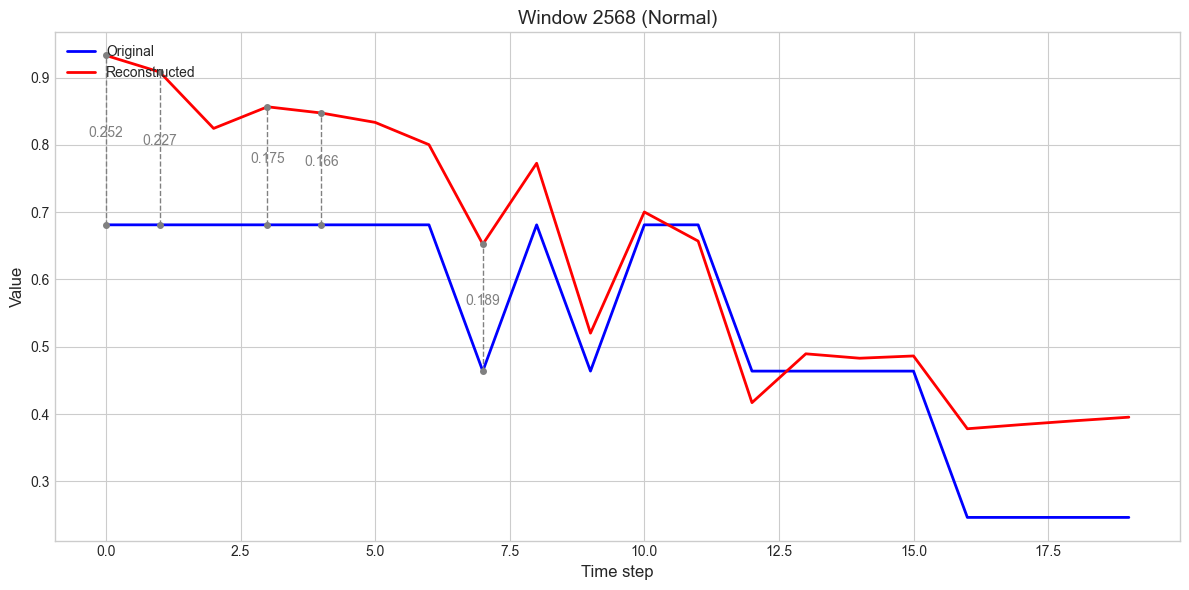

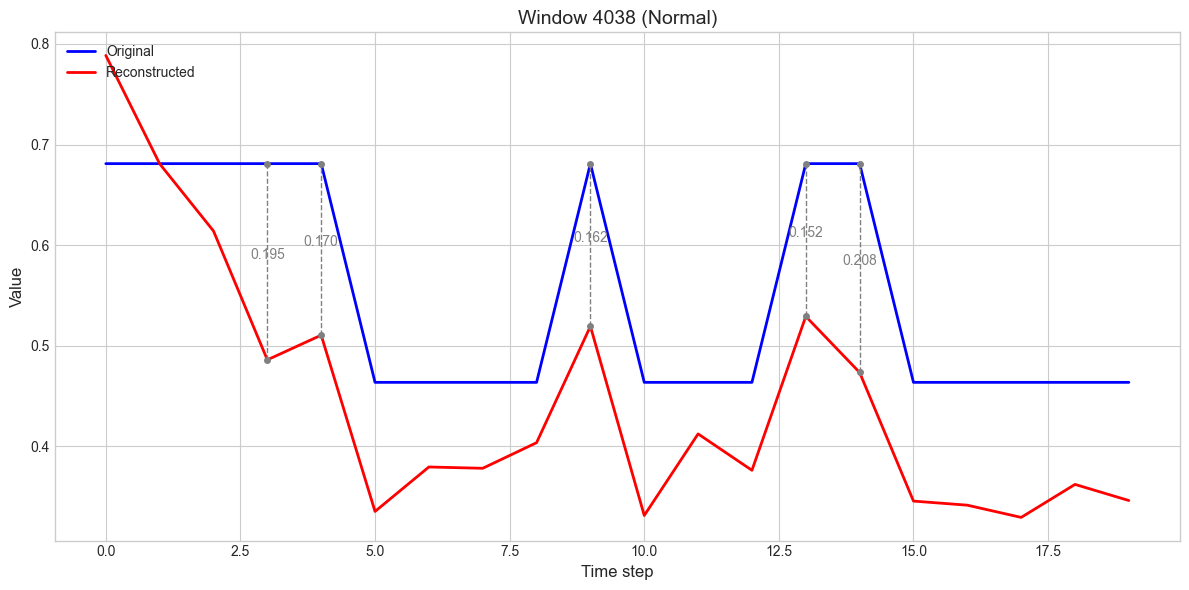

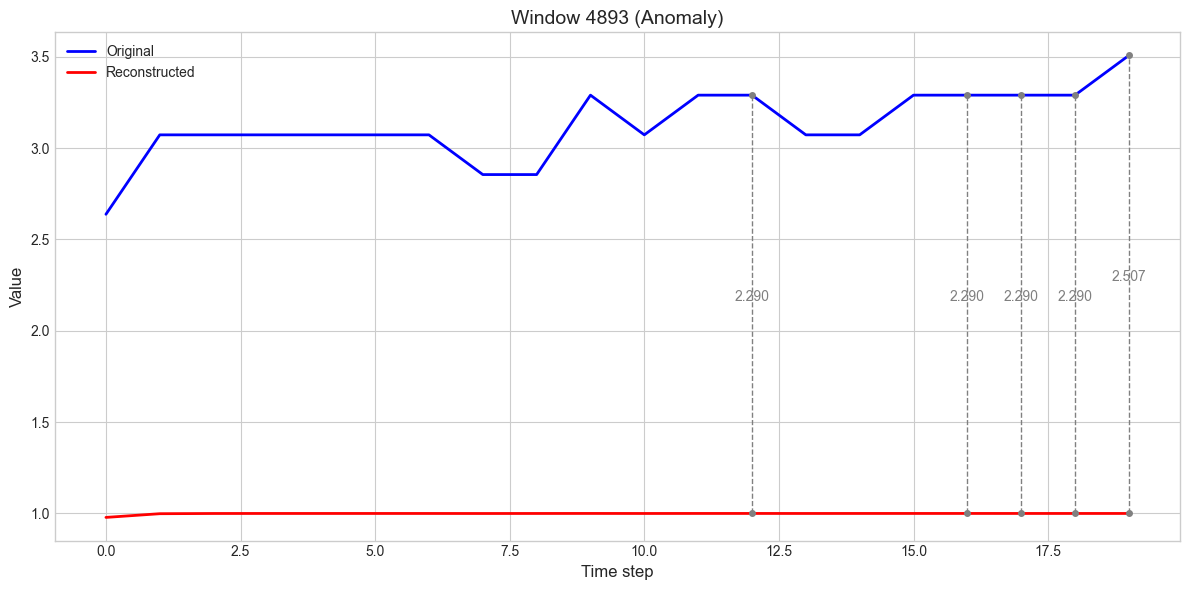

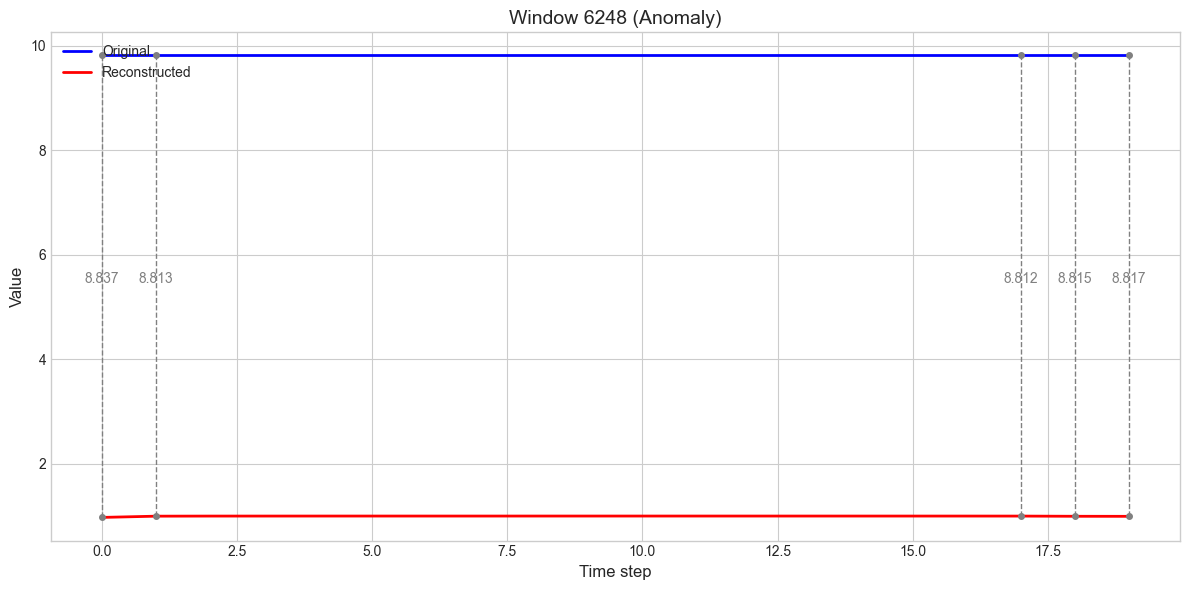

In [52]:
feature = 1
selected_indices = [2568, 4038, 4893, 6248]

for i in selected_indices:
    ts_o = Xt_test[i, :, feature].cpu().numpy()
    ts_r = recon_t[i, :, feature].cpu().numpy()
    t = np.arange(len(ts_o))

    diff = np.abs(ts_o - ts_r)
    idx5 = np.argsort(diff)[-5:]

    plt.figure(figsize=(12, 6))

    plt.plot(t, ts_o, label='Original', color='blue', linewidth=2)
    plt.plot(t, ts_r, label='Reconstructed', color='red', linewidth=2)

    for j in idx5:
        plt.vlines(x=t[j], ymin=min(ts_o[j], ts_r[j]), ymax=max(ts_o[j], ts_r[j]),
                   color='gray', linestyle='--', linewidth=1)
        mid_y = (ts_o[j] + ts_r[j]) / 2
        plt.text(t[j], mid_y, f"{diff[j]:.3f}", color='gray', fontsize=10, ha='center', va='bottom')

        plt.plot(t[j], ts_o[j], marker='o', color='gray', markersize=4)
        plt.plot(t[j], ts_r[j], marker='o', color='gray', markersize=4)

    plt.title(f'Window {i} ({"Normal" if y_test[i] == 0 else "Anomaly"})', fontsize=14)
    plt.xlabel("Time step", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend(fontsize=10, loc='upper left')
    plt.grid(True)
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.tight_layout()
    plt.show()

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Analysis:**
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;A visual comparison of original data alongside its reconstruction for representative normal and anomalous windows highlights the model's performance. In normal windows, the model demonstrates accurate reconstruction, illustrated by the close alignment of reconstructed and original data (red and blue lines respectively) and minimal reconstruction errors consistently around 0.1. Conversely, for anomalous windows, the reconstruction deviates significantly from the original data, resulting in substantial errors, especially exceeding 2.0 towards the end of the window. This discrepancy emphasizes the model's ability to differentiate between typical patterns and novel anomalies.
    
</span>

<span style="font-size:18px;font-weight:bold"> 7.2 Figure 2: ROC Curve </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Code Snippet:**
</span>

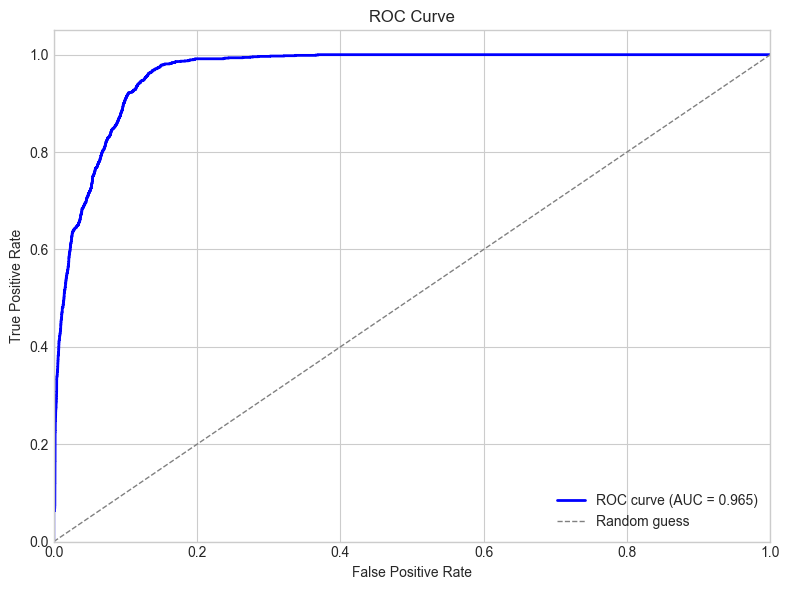

In [53]:
fpr, tpr, _ = roc_curve(y_test, mse_t)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.style.use('seaborn-v0_8-whitegrid')
plt.tight_layout()
plt.show()

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Analysis:**
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This ROC curve demonstrates excellent classification performance by the model. The curve is very close to the top-left corner, and the Area Under the Curve (AUC) is a high 0.965, indicating the model's outstanding ability to distinguish between positive and negative samples, achieving a very high True Positive Rate with an extremely low False Positive Rate. Overall, this model is very well-suited for the current classification task.
    
</span>

<span style="font-size:18px;font-weight:bold"> 7.3 Figure 3: Precision-Recall curve </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Code Snippet:**
</span>

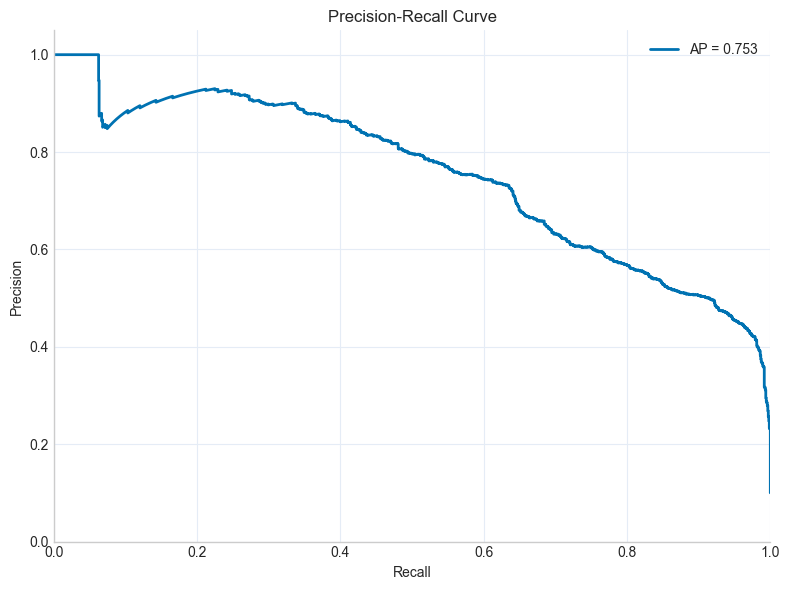

In [54]:
precision, recall, _ = precision_recall_curve(y_test, mse_t)
ap = average_precision_score(y_test, mse_t)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='#0072B2', lw=2, label=f'AP = {ap:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.grid(True, color='#E5ECF6')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.style.use('seaborn-v0_8-whitegrid')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Analysis:**
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This Precision-Recall curve highlights the model's strength in identifying reliable positive samples, particularly its ability to maintain high precision at low recall. The decrease in precision as recall increases reflects the inherent trade-off between these two metrics. In practical applications, the relative importance of precision and recall should be carefully considered, and the model's operating threshold adjusted accordingly to achieve optimal performance.
    
</span>

<span style="font-size:18px;font-weight:bold"> 7.4 Figure 4: MSE vs Timestamp </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Code Snippet:**
</span>

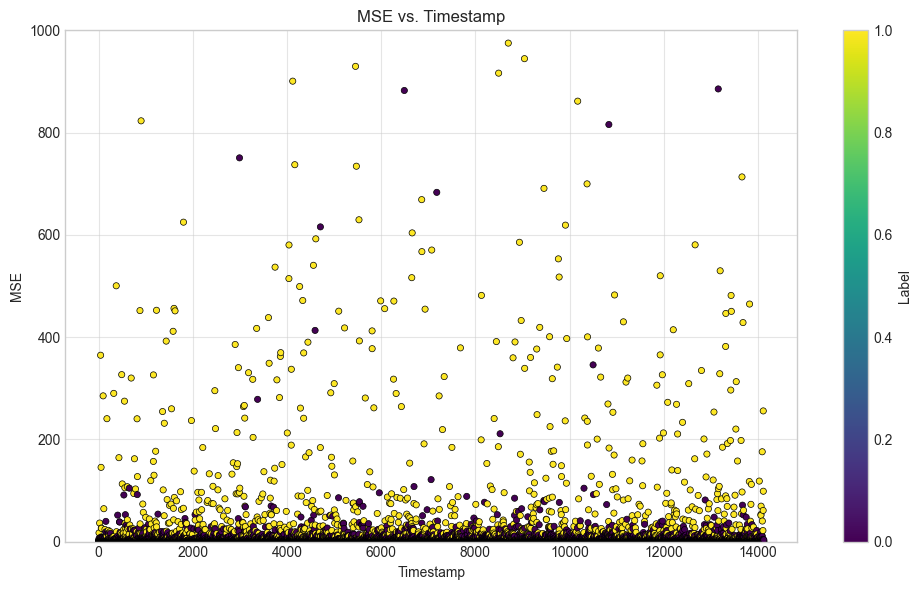

In [55]:
max_mse = 1e3
indices = np.where(mse_t <= max_mse)[0]

mse_t_filtered = mse_t[indices]
y_test_filtered = y_test[indices]
timestamps_filtered = np.arange(len(mse_t_filtered))

plt.figure(figsize=(10, 6))
plt.scatter(timestamps_filtered, mse_t_filtered, c=y_test_filtered, cmap='viridis', s=20, edgecolors='black', linewidths=0.5)

plt.colorbar(label='Label')
plt.xlabel('Timestamp')
plt.ylabel('MSE')
plt.title('MSE vs. Timestamp')
plt.ylim(0, max_mse)
plt.grid(True, linestyle='-', alpha=0.5)
plt.style.use('seaborn-v0_8-whitegrid')
plt.tight_layout()
plt.show()

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Analysis:**
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The plot illustrates the reconstruction error of a model over time. Each point represents the Mean Squared Error (MSE) between the original data at a specific timestamp and its reconstruction by the model. The majority of the data points are clustered near the bottom of the plot, indicating low MSE values and accurate reconstruction during normal operations. However, scattered throughout the timestamp range are isolated points with significantly higher MSE values, suggesting potential anomalies where the model struggles to accurately reconstruct the input.</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The stark contrast in MSE values between normal and anomalous data points reveals the model's success in capturing the underlying patterns of the time series and distinguishing deviations from those patterns. The high MSE associated with anomalies demonstrates the model's sensitivity to abnormal events, indicating that it is not simply overfitting to the training data but rather learning to recognize and flag genuinely unusual occurrences. This suggests the autoencoder is performing well in its intended role, effectively reconstructing normal data while highlighting anomalous events with elevated error values.
    
</span>

<span style="font-size:18px;font-weight:bold"> 7.5 Figure 5: Quantile vs F1-score" </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Code Snippet:**
</span>

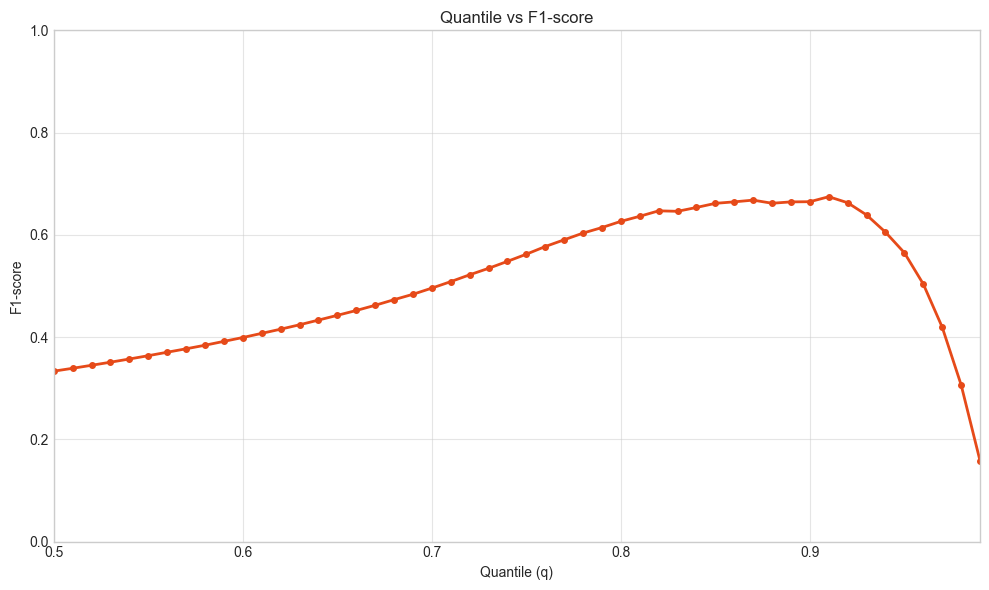

In [56]:
qs = np.linspace(0.5, 0.99, 50)
f1_scores = []
for q in qs:
    thr = np.quantile(mse_t, q)
    y_pred_q = (mse_t > thr).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_q))

plt.figure(figsize=(10, 6))
plt.plot(qs, f1_scores, color='#E64A19', linewidth=2, marker='o', markersize=4)

plt.xlabel('Quantile (q)')
plt.ylabel('F1-score')
plt.title('Quantile vs F1-score')
plt.grid(True, linestyle='-', alpha=0.5)
plt.xlim(0.5, 0.99)
plt.ylim(0, 1)
plt.xticks(np.arange(0.5, 1.0, 0.1))
plt.style.use('seaborn-v0_8-whitegrid')
plt.tight_layout()
plt.show()

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">**Analysis:**
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This plot visualizes the relationship between the quantile used as a threshold for anomaly detection and the resulting F1-score on the test set. The quantile represents the threshold above which a data point's reconstruction error is classified as an anomaly. By varying this quantile and calculating the F1-score for each threshold, the plot helps identify the optimal threshold that maximizes the balance between precision and recall. This is essential for effective anomaly detection, as it helps to minimize both false positives and false negatives.
    
</span>

<span style="font-size:22px;font-weight:bold"> 8.Results Analysis </span>

<span style="font-size:18px;font-weight:bold"> 8.1 Overall Performance </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.Accuracy: 93.99% - This indicates that the model is generally able to correctly classify most data points, including both normal and anomalous samples. High accuracy is a positive sign, but it needs to be evaluated in conjunction with other metrics, especially considering the common situation of class imbalance in anomaly detection tasks.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.F1-score: 67.89% - The F1-score is the harmonic mean of precision and recall, and it comprehensively considers the model's ability to identify anomalous samples. An F1-score of 67.89% indicates that the model has achieved a certain balance between accurately identifying anomalous samples and covering all actual anomalous samples, but there is still room for improvement.
</span>

<span style="font-size:18px;font-weight:bold"> 8.2 Class Performance </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.Precision:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Class 0 (Normal): 96.00% - Of the data points predicted as normal by the model, 96.00% are actually normal.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Class 1 (Anomalous): 73.00% - Of the data points predicted as anomalous by the model, 73.00% are actually anomalous.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The precision for anomalous samples is relatively low, which means that the model may misclassify some normal samples as anomalous (false positives).
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.Recall:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Class 0 (Normal): 97.39% - The model is able to identify 97.39% of the actual normal data points.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Class 1 (Anomalous): 63.46% - The model is able to identify 63.46% of the actual anomalous data points.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The recall for anomalous samples is relatively low, which means that the model may miss some actual anomalous samples (false negatives).
</span>

<span style="font-size:18px;font-weight:bold"> 8.3 Confusion Matrix </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;True Positives (TP): 903 - The number of samples correctly predicted as anomalous by the model.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;True Negatives (TN): 12473 - The number of samples correctly predicted as normal by the model.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;False Positives (FP): 334 - The number of normal samples incorrectly predicted as anomalous by the model (Type I error).<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;False Negatives (FN): 520 - The number of anomalous samples incorrectly predicted as normal by the model (Type II error).<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The confusion matrix clearly shows the model's prediction performance for each class, providing a more intuitive understanding of the model's strengths and weaknesses. 
</span>

<span style="font-size:18px;font-weight:bold"> 8.4 Threshold </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Best Threshold on Validation Set: 13.338430 - This threshold was obtained by optimizing the F1-score on the validation set and is used to distinguish between normal and anomalous data.
</span>

<span style="font-size:18px;font-weight:bold"> 8.5 Potential Issues and Directions for Improvement </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1. Class Imbalance: The number of normal samples is much larger than the number of anomalous samples. This can cause the model to be biased towards predicting normal samples, thereby affecting the performance of anomaly detection. You can try the following methods to solve the class imbalance problem:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Resampling: Oversample the anomalous samples or undersample the normal samples.<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Cost-Sensitive Learning: Assign different costs to errors for different classes to make      the model pay more attention to the anomalous samples.<br>
&nbsp;&nbsp;&nbsp;2. High False Negative Rate: The model may miss some actual anomalous samples. This is unacceptable in some application scenarios (e.g., security monitoring). You can try lowering the threshold to increase the recall rate, but this may cause the precision rate to decrease.<br>
&nbsp;&nbsp;&nbsp;3. Model Complexity: Evaluate whether the model is too complex, leading to overfitting. You can try using a simpler model or increasing regularization.

<br>
&nbsp;&nbsp;&nbsp;4. Feature Engineering: Try adding more features related to anomalies to improve the model's ability to distinguish.<br>
&nbsp;&nbsp;&nbsp;5. Ensemble Methods: Try using ensemble methods (e.g., integrating multiple different anomaly detection models) to improve overall performance.
</span>

<span style="font-size:22px;font-weight:bold"> 9.Conclusion </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In conclusion, this project leverages the power of a ConvBiGRU autoencoder to effectively detect anomalies within multivariate time-series server machine data. By combining convolutional layers for feature extraction with the sequence learning capabilities of bidirectional GRUs, the model is well-suited to capture the complex interdependencies present in server performance metrics. The unsupervised nature of the approach allows for the identification of deviations from normal operating patterns without requiring labeled anomaly data, making it a valuable tool for proactive server health monitoring and early detection of potential issues. The results of this project have the potential to significantly improve server stability and reduce downtime by enabling timely intervention and mitigation of anomalous conditions.
</span>